I. IMPORT LIBRARIES

In [152]:
import numpy as np
import pandas as pd
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

II. PREPARE DATA

1. Read data

In [153]:
df =pd.read_csv('data.csv')
print(df.shape)

(35788, 15)


In [154]:
print(df.dtypes)

Thương hiệu           object
Model                 object
Tình trạng            object
Số Km đã đi            int64
Xuất xứ               object
Kiểu dáng             object
Hộp số                object
Số chỗ ngồi            int64
Số cửa                 int64
Dẫn động              object
Giá thành              int64
Loại nhiên liệu       object
Dung tích động cơ    float64
Đơn vị động cơ        object
Tuổi                   int64
dtype: object


- We found that the "Động cơ" attribute could be separated into more useful attributes, so we'll split them into 3 attributes.

In [155]:
# df[['Loại nhiên liệu', 'Dung tích động cơ', 'Đơn vị động cơ']] = df['Động cơ'].str.extract(r'(\D+) (\d+\.\d+) (\w+)')
# df=df.drop(['Động cơ'],axis =1)

In [156]:

missing_values = df.isnull().sum()
print(missing_values)

Thương hiệu          0
Model                0
Tình trạng           0
Số Km đã đi          0
Xuất xứ              0
Kiểu dáng            0
Hộp số               0
Số chỗ ngồi          0
Số cửa               0
Dẫn động             0
Giá thành            0
Loại nhiên liệu      0
Dung tích động cơ    0
Đơn vị động cơ       0
Tuổi                 0
dtype: int64


- However, the result is creating some columns with null values, but that is not much compared to the original data so we will delete it so the model works better.

In [157]:

# df = df.dropna(subset=['Loại nhiên liệu'])
# df['Tuổi'] = 2023 - df['Năm sản xuất']
# df = df.drop(['Năm sản xuất'], axis=1)


2. Delete the target variable and split the variables

In [158]:
X = df.drop('Giá thành', axis=1)
y = df['Giá thành']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [159]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 28630 entries, 19176 to 15795
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Thương hiệu        28630 non-null  object 
 1   Model              28630 non-null  object 
 2   Tình trạng         28630 non-null  object 
 3   Số Km đã đi        28630 non-null  int64  
 4   Xuất xứ            28630 non-null  object 
 5   Kiểu dáng          28630 non-null  object 
 6   Hộp số             28630 non-null  object 
 7   Số chỗ ngồi        28630 non-null  int64  
 8   Số cửa             28630 non-null  int64  
 9   Dẫn động           28630 non-null  object 
 10  Loại nhiên liệu    28630 non-null  object 
 11  Dung tích động cơ  28630 non-null  float64
 12  Đơn vị động cơ     28630 non-null  object 
 13  Tuổi               28630 non-null  int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 3.3+ MB
None


3. Delete unnecessary columns

- We found that the "Phiên bản" attribute has a lot of missing data and is not very important, so we will remove it along with the "Đơn vị động cơ" attribute because it only has a single value.

In [160]:
# X_train.drop("Phiên bản", axis = 1, inplace = True)
# X_test.drop("Phiên bản", axis = 1, inplace = True)
X_train.drop(["Đơn vị động cơ", "Số chỗ ngồi", "Số cửa"], axis = 1, inplace = True)
X_test.drop(["Đơn vị động cơ", "Số chỗ ngồi", "Số cửa"], axis = 1, inplace = True)
# X_train.drop("Model", axis = 1, inplace = True)
# X_test.drop("Model", axis = 1, inplace = True)

In [161]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 28630 entries, 19176 to 15795
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Thương hiệu        28630 non-null  object 
 1   Model              28630 non-null  object 
 2   Tình trạng         28630 non-null  object 
 3   Số Km đã đi        28630 non-null  int64  
 4   Xuất xứ            28630 non-null  object 
 5   Kiểu dáng          28630 non-null  object 
 6   Hộp số             28630 non-null  object 
 7   Dẫn động           28630 non-null  object 
 8   Loại nhiên liệu    28630 non-null  object 
 9   Dung tích động cơ  28630 non-null  float64
 10  Tuổi               28630 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 2.6+ MB
None


4. Convert non-numeric variables into dummy variables

In [162]:
X_train = pd.get_dummies(X_train,
                         columns = ["Model","Dung tích động cơ",'Loại nhiên liệu',"Thương hiệu", "Tình trạng","Xuất xứ","Kiểu dáng","Hộp số","Dẫn động"],
                         drop_first = True)

In [163]:
X_test = pd.get_dummies(X_test,
                         columns = ["Model","Dung tích động cơ","Loại nhiên liệu","Thương hiệu", "Tình trạng","Xuất xứ","Kiểu dáng","Hộp số","Dẫn động"],
                         drop_first = True)

5. It might be possible that the dummy column creation would be different in test and train data, thus, I'd fill in all missing columns with zeros.

In [164]:
missing_cols = list(set(X_train.columns) - set(X_test.columns))
X_test = pd.concat([X_test, pd.DataFrame(0, index=X_test.index, columns=missing_cols)], axis=1)

X_test = X_test[X_train.columns]

6. Finally, as the last step of data processing, I'll scale the data.

In [165]:
standardScaler = StandardScaler()
standardScaler.fit(X_train)
X_train = standardScaler.transform(X_train)
X_test = standardScaler.transform(X_test)

In [166]:
print(X_train.dtype)

float64


III.    MODEL

1. RAMDOM FOREST MODEL

-  We use the scikit-learn library to build a random forest model for the data set and print the model's r2_score value.

In [167]:
rf = RandomForestRegressor(n_estimators = 100,random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
r2_rf=r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print(f"R-squared for Random Forest: {r2_rf}")
print(f"MAE for Random Forest: {mae_rf}")
print(f"MSE for Random Forest: {mse_rf}")
print(f"RMSE for Random Forest: {rmse_rf}")

R-squared for Random Forest: 0.8746017763614948
MAE for Random Forest: 128.67656490224232
MSE for Random Forest: 389384.26618519716
RMSE for Random Forest: 624.0066235106781


- Hyperparameter tuning

In [168]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_reg = RandomForestRegressor(random_state=42)
random_search_rf = RandomizedSearchCV(estimator=rf_reg, param_distributions=param_dist, n_iter=10, scoring='r2', cv=3, n_jobs=-1)
random_search_rf.fit(X_train, y_train)
print("Best Parameters for Random Forest:", random_search_rf.best_params_)

Best Parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 30}


In [169]:
y_pred_random_search_rf_best =random_search_rf.best_estimator_.predict(X_test)
r2_rf_best = r2_score(y_test, y_pred_random_search_rf_best)
r2_rf_best=r2_score(y_test, y_pred_random_search_rf_best)
mae_rf_best = mean_absolute_error(y_test, y_pred_random_search_rf_best)
mse_rf_best = mean_squared_error(y_test, y_pred_random_search_rf_best)
rmse_rf_best = np.sqrt(mse_rf_best)
print(f"R-squared for Random Forest(Randomized): {r2_rf_best}")
print(f"MAE for Random Forest(Randomized): {mae_rf_best}")
print(f"MSE for Random Forest(Randomized): {mse_rf_best}")
print(f"RMSE for Random Forest(Randomized): {rmse_rf_best}")


R-squared for Random Forest(Randomized): 0.8752595678008797
MAE for Random Forest(Randomized): 135.16427307007064
MSE for Random Forest(Randomized): 387341.70426130475
RMSE for Random Forest(Randomized): 622.3678207148123


2. LINEAR REGRESSION MODEL

In [170]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
print(f"R-squared for Linear Regression: {r2_lr}")
print(f"MAE for Linear Regression: {mae_lr}")
print(f"MSE for Linear Regression: {mse_lr}")
print(f"RMSE for Linear Regression: {rmse_lr}")

R-squared for Linear Regression: -1.1918519684097178e+23
MAE for Linear Regression: 15531581252732.844
MSE for Linear Regression: 3.700916892239742e+29
RMSE for Linear Regression: 608351616439024.6


+ From the results, it is seen that the linear relationship between the attributes is very small, so attempting to implement this model is not feasible.

3. DECISION TREE MODEL

In [171]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)


r2_dt = r2_score(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
print(f"R-squared for Decision Tree: {r2_dt}")
print(f"MAE for Decision Tree: {mae_dt}")
print(f"MSE for Decision Tree: {mse_dt}")
print(f"RMSE for Decision Tree: {rmse_dt}")

R-squared for Decision Tree: 0.8555291975267258
MAE for Decision Tree: 133.14246070996396
MSE for Decision Tree: 448608.0884878554
RMSE for Decision Tree: 669.7821201613666


- Hyperparameter tuning

In [172]:
parameters = {
    'max_depth': [None,  10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt = DecisionTreeRegressor(random_state=42)

grid_search_dt = GridSearchCV(estimator=dt, param_grid=parameters, scoring='r2', cv=3, n_jobs=-1)
grid_search_dt.fit(X_train, y_train)
print("Best Parameters for Decision Tree:", grid_search_dt.best_params_)

Best Parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10}


In [173]:
y_pred_dt_best = grid_search_dt.best_estimator_.predict(X_test);
r2_dt_best = r2_score(y_test, y_pred_dt_best)
mae_dt_best = mean_absolute_error(y_test, y_pred_dt_best)
mse_dt_best = mean_squared_error(y_test, y_pred_dt_best)
rmse_dt_best = np.sqrt(mse_dt_best)
print(f"R-squared for Decision Tree (optimized): {r2_dt_best}")
print(f"MAE for Decision Tree (optimized): {mae_dt_best}")
print(f"MSE for Decision Tree (optimized): {mse_dt_best}")
print(f"RMSE for Decision Tree (optimized): {rmse_dt_best}")

R-squared for Decision Tree (optimized): 0.891923361239809
MAE for Decision Tree (optimized): 135.9404173929737
MSE for Decision Tree (optimized): 335597.59823007055
RMSE for Decision Tree (optimized): 579.3078613570426


4. XG BOOT

In [174]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)
xg_reg.fit(X_train, y_train)


y_pred_xgb = xg_reg.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
print(f"R-squared for XGBoost: {r2_xgb}")
print(f"MAE for XGBoost: {mae_xgb}")
print(f"MSE for XGBoost: {mse_xgb}")
print(f"RMSE for XGBoost: {rmse_xgb}")


R-squared for XGBoost: 0.874214373677163
MAE for XGBoost: 162.10217312282276
MSE for XGBoost: 390587.2219016318
RMSE for XGBoost: 624.9697767905516


- Hyperparameter tuning

In [175]:
param_grid_xgb = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1]
}

xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search_xgb = GridSearchCV(estimator=xg_reg, param_grid=param_grid_xgb, scoring='r2', cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)
print(grid_search_xgb.best_params_)


{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


In [176]:
y_pred_xgb_best = grid_search_xgb.best_estimator_.predict(X_test)
r2_xgb_best = r2_score(y_test, y_pred_xgb_best)
mae_xgb_best = mean_absolute_error(y_test, y_pred_xgb_best)
mse_xgb_best = mean_squared_error(y_test, y_pred_xgb_best)
rmse_xgb_best = np.sqrt(mse_xgb_best)
print(f"R-squared for XGBoost (optimized): {r2_xgb_best}")
print(f"MAE for XGBoost (optimized): {mae_xgb_best}")
print(f"MSE for XGBoost (optimized): {mse_xgb_best}")
print(f"RMSE for XGBoost (optimized): {rmse_xgb_best}")


R-squared for XGBoost (optimized): 0.8794334333111821
MAE for XGBoost (optimized): 202.52397673660965
MSE for XGBoost (optimized): 374381.0935626235
RMSE for XGBoost (optimized): 611.8668920301404


5. GRADIENT BOOSTING MODEL

In [177]:
gbm = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbm.fit(X_train, y_train)
y_pred_gbm = gbm.predict(X_test)
r2_gbm = r2_score(y_test, y_pred_gbm)
mae_gbm = mean_absolute_error(y_test, y_pred_gbm)
mse_gbm = mean_squared_error(y_test, y_pred_gbm)
rmse_gbm = np.sqrt(mse_gbm)
print(f"R-squared for GBM : {r2_gbm}")
print(f"MAE for GBM : {mae_gbm}")
print(f"MSE for GBM: {mse_gbm}")
print(f"RMSE for GBM: {rmse_gbm}")


R-squared for GBM : 0.8201470714606502
MAE for GBM : 315.8806398951024
MSE for GBM: 558476.017989215
RMSE for GBM: 747.3125303306609


- Hyperparameter tuning

In [178]:
from sklearn.model_selection import  RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
gbm = GradientBoostingRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=gbm, param_distributions=param_dist, n_iter=10, scoring='r2', cv=3, random_state=42)
random_search.fit(X_train, y_train)
print(random_search.best_params_)


{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 4, 'learning_rate': 0.2}


In [179]:
y_pred_gbm_best = random_search.best_estimator_.predict(X_test)
r2_gbm_best = r2_score(y_test, y_pred_gbm_best)
mae_gbm_best = mean_absolute_error(y_test, y_pred_gbm_best)
mse_gbm_best = mean_squared_error(y_test, y_pred_gbm_best)
rmse_gbm_best = np.sqrt(mse_gbm_best)
print(f"R-squared for GBM (optimized): {r2_gbm_best}")
print(f"MAE for GBM (optimized): {mae_gbm_best}")
print(f"MSE for GBM (optimized): {mse_gbm_best}")
print(f"RMSE for GBM (optimized): {rmse_gbm_best}")

R-squared for GBM (optimized): 0.8635980884217508
MAE for GBM (optimized): 177.58903573808047
MSE for GBM (optimized): 423552.71633884415
RMSE for GBM (optimized): 650.8092780061177


6.  NEURAL NETWORK MODEL

In [180]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test.values)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(in_features=X_train.shape[1], out_features=64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=32, out_features=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x


model = NeuralNetwork()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 1000
for epoch in range(num_epochs):
    inputs = Variable(X_train_tensor)
    labels = Variable(y_train_tensor)

    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs.squeeze(), labels)
    loss.backward()

    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')


with torch.no_grad():
    model.eval()
    y_pred_nn = model(Variable(X_test_tensor)).squeeze().numpy()

r2_nn = r2_score(y_test, y_pred_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
mse_nn = mean_squared_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)
print(f"R-squared for NeuralNetwork : {r2_nn}")
print(f"MAE for NeuralNetwork : {mae_nn}")
print(f"MSE for NeuralNetwork: {mse_nn}")
print(f"RMSE for NeuralNetwork: {rmse_nn}")




Epoch [100/1000], Loss: 4196945.5
Epoch [200/1000], Loss: 2389425.5
Epoch [300/1000], Loss: 1290033.75
Epoch [400/1000], Loss: 1017780.125
Epoch [500/1000], Loss: 895757.125
Epoch [600/1000], Loss: 839633.4375
Epoch [700/1000], Loss: 810254.25
Epoch [800/1000], Loss: 790459.25
Epoch [900/1000], Loss: 774611.1875
Epoch [1000/1000], Loss: 761191.5
R-squared for NeuralNetwork : 0.8039518661804845
MAE for NeuralNetwork : 236.97978622289168
MSE for NeuralNetwork: 608765.0726564896
RMSE for NeuralNetwork: 780.2339858378956


IV. MODEL EVALUATION

In [181]:
import matplotlib.pyplot as plt




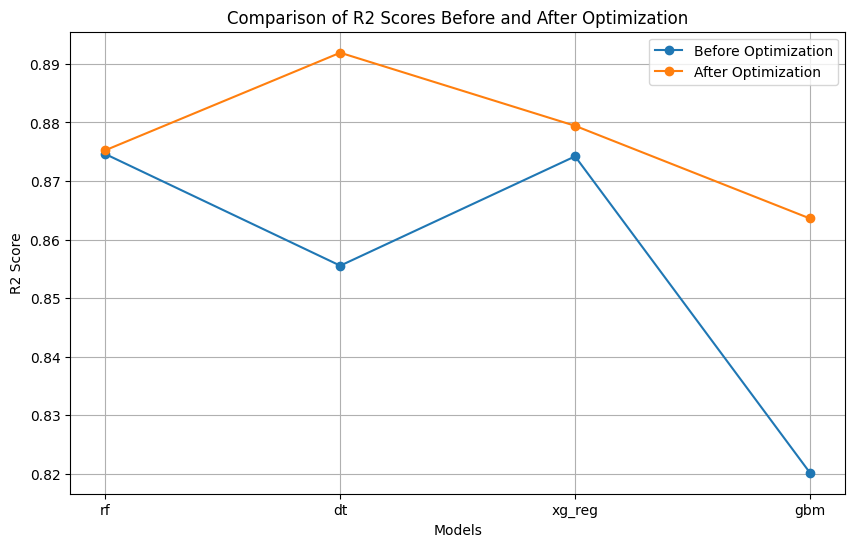

In [182]:
models = ['rf', 'dt', 'xg_reg', 'gbm']
r2_before_opt = [r2_rf, r2_dt, r2_xgb, r2_gbm] 
r2_after_opt = [r2_rf_best, r2_dt_best, r2_xgb_best, r2_gbm_best]
plt.figure(figsize=(10, 6))
plt.plot(models, r2_before_opt, marker='o', linestyle='-', label='Before Optimization')
plt.plot(models, r2_after_opt, marker='o', linestyle='-', label='After Optimization')

plt.xlabel('Models')
plt.ylabel('R2 Score')
plt.title('Comparison of R2 Scores Before and After Optimization')
plt.legend()
plt.grid(True)
plt.show()


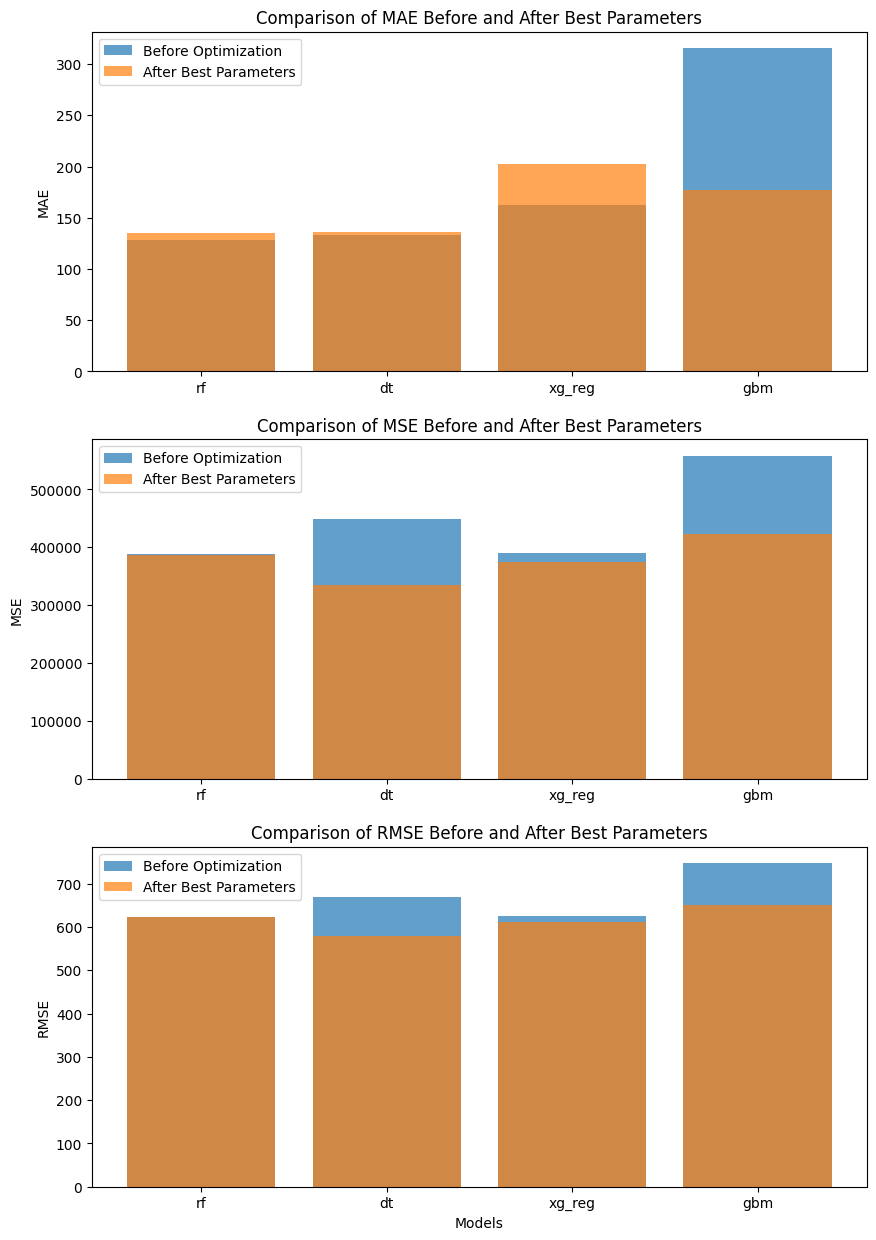

In [183]:
mae_before_opt = [mae_rf, mae_dt, mae_xgb, mae_gbm]
mae_after_opt = [mae_rf_best, mae_dt_best, mae_xgb_best, mae_gbm_best]

mse_before_opt = [mse_rf, mse_dt, mse_xgb, mse_gbm]
mse_after_opt = [mse_rf_best, mse_dt_best, mse_xgb_best, mse_gbm_best]

rmse_before_opt = [rmse_rf, rmse_dt, rmse_xgb, rmse_gbm]
rmse_after_opt = [rmse_rf_best, rmse_dt_best, rmse_xgb_best, rmse_gbm_best]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# MAE
axes[0].bar(models, mae_before_opt, label='Before Optimization', alpha=0.7)
axes[0].bar(models, mae_after_opt, label='After Best Parameters', alpha=0.7)
axes[0].set_ylabel('MAE')
axes[0].set_title('Comparison of MAE Before and After Best Parameters')
axes[0].legend()

# MSE
axes[1].bar(models, mse_before_opt, label='Before Optimization', alpha=0.7)
axes[1].bar(models, mse_after_opt, label='After Best Parameters', alpha=0.7)
axes[1].set_ylabel('MSE')
axes[1].set_title('Comparison of MSE Before and After Best Parameters')
axes[1].legend()

# RMSE
axes[2].bar(models, rmse_before_opt, label='Before Optimization', alpha=0.7)
axes[2].bar(models, rmse_after_opt, label='After Best Parameters', alpha=0.7)
axes[2].set_ylabel('RMSE')
axes[2].set_title('Comparison of RMSE Before and After Best Parameters')
axes[2].legend()

plt.xlabel('Models')
plt.show()

In [184]:
import numpy as np
r2_before_opt = [r2_rf, r2_dt, r2_xgb, r2_gbm] 
r2_after_opt = [r2_rf_best, r2_dt_best, r2_xgb_best, r2_gbm_best] 
print("Mean R2 Before Optimization:", np.mean(r2_before_opt))
print("Mean R2 After Optimization:", np.mean(r2_after_opt))
print("Median R2 Before Optimization:", np.median(r2_before_opt))
print("Median R2 After Optimization:", np.median(r2_after_opt))
print("Standard Deviation R2 Before Optimization:", np.std(r2_before_opt))
print("Standard Deviation R2 After Optimization:", np.std(r2_after_opt))


Mean R2 Before Optimization: 0.8561231047565085
Mean R2 After Optimization: 0.8775536126934054
Median R2 Before Optimization: 0.8648717856019444
Median R2 After Optimization: 0.8773465005560308
Standard Deviation R2 Before Optimization: 0.022155039003275635
Standard Deviation R2 After Optimization: 0.010124755534178966


- The results show that the models are significantly improved after performing parameter optimization

-   After evaluation, we found the dt model to be the best model for this project

V.  GET INPUT

-   We will use the most effective model, Decision Tree, to perform this task

In [197]:
X = df.drop('Giá thành', axis=1)
y = df['Giá thành']
X.drop(["Đơn vị động cơ", "Số chỗ ngồi", "Số cửa"], axis=1, inplace=True)
X = pd.get_dummies(X,
                   columns=["Thương hiệu", "Tình trạng", "Xuất xứ", "Kiểu dáng", "Hộp số", "Dẫn động",
                            "Loại nhiên liệu", "Model"],
                   drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
dt = DecisionTreeRegressor(max_depth=None, min_samples_leaf=2, min_samples_split=10, random_state=42)
dt.fit(X_scaled, y)
user_input = {
    "Thương hiệu": input("Nhập Thương hiệu: "),
    "Model": input("Nhập Model: "),
    "Tình trạng": input("Nhập Tình trạng (New hoặc Used): "),
    "Số Km đã đi": float(input("Nhập Số Km đã đi: ")),
    "Xuất xứ": input("Nhập Xuất xứ: (Domestic hoặc Imported)"),
    "Kiểu dáng": input("Nhập Kiểu dáng: "),
    "Hộp số": input("Nhập Hộp số: (Automatic hoặc Manual)"),
    "Số chỗ ngồi": int(input("Nhập Số chỗ ngồi: ")),
    "Số cửa": int(input("Nhập Số cửa: ")),
    "Dẫn động": input("Nhập Dẫn động: "),
    "Loại nhiên liệu": input("Nhập Loại nhiên liệu: "),
    "Dung tích động cơ": float(input("Nhập Dung tích động cơ: ")),
    "Tuổi": int(input("Nhập Tuổi: "))
}

user_df = pd.DataFrame([user_input])
columns_to_drop = ["Đơn vị động cơ", "Số chỗ ngồi", "Số cửa"]
columns_to_drop_existing = [col for col in columns_to_drop if col in user_df.columns]
user_df.drop(columns_to_drop_existing, axis=1, inplace=True)
user_df = pd.get_dummies(user_df,
                         columns=["Thương hiệu", "Tình trạng", "Xuất xứ", "Kiểu dáng", "Hộp số", "Dẫn động",
                                  "Loại nhiên liệu", "Model"],
                         drop_first=True)
missing_cols = list(set(X.columns) - set(user_df.columns))
user_df = pd.concat([user_df, pd.DataFrame(0, index=user_df.index, columns=missing_cols)], axis=1)
user_df = user_df[X.columns]
user_df_scaled = scaler.transform(user_df)
predicted_price = dt.predict(user_df_scaled)
print(f"Predicted price: {predicted_price[0]}")


Dự đoán giá cả: 550.0
